In [33]:
import os
os.environ["METIS_DLL"] = "/home/budvin/research/Partitioning/metis-5.1.0/build/Linux-x86_64/libmetis/libmetis.so"


import networkx as nx
import matplotlib.pyplot as plt
import metis
import random
import math
import pprint
import numpy as np

import pandas as pd
from collections import defaultdict 
from operator import itemgetter
import copy



In [34]:
pp = pprint.PrettyPrinter(indent=2)
# random.seed(1)
def display(x):
    print("")
    # print(x)
    pp.pprint(x)
    print("")

In [35]:
def xy_to_hilbert_index (coord,n):
    x,y = coord
    d=0
    s=n//2
    while s>0:
        rx = 1 if (x & s) > 0 else 0
        ry = 1 if (y & s) > 0 else 0
        d += s * s * ((3 * rx) ^ ry)

        # rot procedure
        if ry==0:
            if rx ==1:
                x = n-1 -x
                y = n-1 -y
            x,y = y,x

        s=s//2
    # }
    return d

def get_hilbert_index_2d(data_points,N):
    hilbert_indices_temp = [[xy_to_hilbert_index(data,N),i] for i,data in enumerate(data_points)]


    hilbert_indices_temp_sorted = sorted(hilbert_indices_temp, key=itemgetter(0))

    hilbert_order = [x[1] for x in hilbert_indices_temp_sorted]

    hilbert_indices_final = [-1 for _ in range((len(data_points)))]


    for i,x in enumerate(hilbert_indices_temp_sorted):
        hilbert_indices_final[x[1]] = i
    return {'hilbert_index':hilbert_indices_final,'hilbert_order':hilbert_order}



In [36]:
def cluster_to_color(ci):

    arr=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
    part=""
    random.seed(ci)

    for i in range(6):
        idx = random.randint(1,2 << 32)%16
        part+=str(arr[idx])
    return f"#{part}"

In [37]:
G = nx.Graph()
N_2_pow = 6
N = 2**N_2_pow
fig_size = 15
partition_count = 5
results = pd.DataFrame(columns=['method', 'np','lambda_expr', 'lambda','rho_expr', 'rho'])
data_points = []
#NxN grid
for i in range(N*N):
    G.add_node(i,pos=(i//N,i%N))
    data_points.append([i//N,i%N])

for i in range(N*N):
    x = i//N
    y = i % N
    # neighbors = [[x-1,y-1],[x-1,y],[x-1,y+1],[x,y-1],[x,y+1],[x+1,y-1],[x+1,y],[x+1,y+1]]
    neighbors = [[x-1,y],[x,y-1],[x,y+1],[x+1,y]]

    for ni in neighbors:
        if 0<=ni[0]<N and 0<=ni[1]<N:
            ni_index = N*ni[0] + ni[1]
            G.add_edge(i,ni_index)

node_count = G.number_of_nodes()
pos = nx.nx_agraph.graphviz_layout(G)
# data_points = [pos[key] for key in sorted(pos.keys())]
# print(data_points[:10])
# print(pos)



# plt.figure(figsize=(fig_size,fig_size))
# nx.draw_networkx(G, pos)

# plt.show()

In [38]:
def xy_to_morton_index (coord):
    x,y = coord
    answer = 0
    for i in range(0,64//3):
        answer = answer | ((x & (1 << i)) << (2*i)) | ((y & (1 << i)) << (2*i+1))

    return answer



def get_morton_index_3d(data_points):

    all_coord_values = []
    for idx, d in enumerate(data_points):
        # keep pair [value,location]
        all_coord_values.append([
            d[0],[idx,0]
        ])
        all_coord_values.append([
            d[1],[idx,1]
        ])

    all_coord_values_sorted = sorted(all_coord_values, key=itemgetter(0))

    data_points_adjusted = [[-1,-1] for _ in range(len(data_points))]
    for i, x in enumerate(all_coord_values_sorted):
        data_points_adjusted[x[1][0]][x[1][1]] = i
    morton_indices_temp = [[xy_to_morton_index(data),i] for i,data in enumerate(data_points_adjusted)]


    morton_indices_temp_sorted = sorted(morton_indices_temp, key=itemgetter(0))

    morton_order = [x[1] for x in morton_indices_temp_sorted]

    morton_indices_final = [-1 for _ in range((len(data_points)))]


    for i,x in enumerate(morton_indices_temp_sorted):
        morton_indices_final[x[1]] = i
    return {'morton_index':morton_indices_final,'morton_order':morton_order}

In [39]:
# morton = get_morton_index_3d(data_points)
# morton_labels = morton['morton_index']
# morton_order = morton['morton_order']


morton = get_hilbert_index_2d(data_points,N)
morton_labels = morton['hilbert_index']
morton_order = morton['hilbert_order']


morton_G = nx.Graph()

for i in range(N*N):
    morton_G.add_node(i)


for i in range(len(morton_order)-1):
    morton_G.add_edge(morton_order[i],morton_order[i+1])

# plt.figure(figsize=(fig_size,fig_size))

# nx.draw_networkx(morton_G, pos)
# plt.show()

grid_in_morton_order:  [0, 64, 65, 1, 2, 3, 67, 66, 130, 131, 195, 194, 193, 129, 128, 192, 256, 257, 321, 320, 384, 448, 449, 385, 386, 450, 451, 387, 323, 322, 258, 259, 260, 261, 325, 324, 388, 452, 453, 389, 390, 454, 455, 391, 327, 326, 262, 263, 199, 135, 134, 198, 197, 196, 132, 133, 69, 68, 4, 5, 6, 70, 71, 7, 8, 9, 73, 72, 136, 200, 201, 137, 138, 202, 203, 139, 75, 74, 10, 11, 12, 76, 77, 13, 14, 15, 79, 78, 142, 143, 207, 206, 205, 141, 140, 204, 268, 332, 333, 269, 270, 271, 335, 334, 398, 399, 463, 462, 461, 397, 396, 460, 459, 458, 394, 395, 331, 267, 266, 330, 329, 265, 264, 328, 392, 393, 457, 456, 520, 521, 585, 584, 648, 712, 713, 649, 650, 714, 715, 651, 587, 586, 522, 523, 524, 588, 589, 525, 526, 527, 591, 590, 654, 655, 719, 718, 717, 653, 652, 716, 780, 844, 845, 781, 782, 783, 847, 846, 910, 911, 975, 974, 973, 909, 908, 972, 971, 970, 906, 907, 843, 779, 778, 842, 841, 777, 776, 840, 904, 905, 969, 968, 967, 903, 902, 966, 965, 964, 900, 901, 837, 836, 772, 773

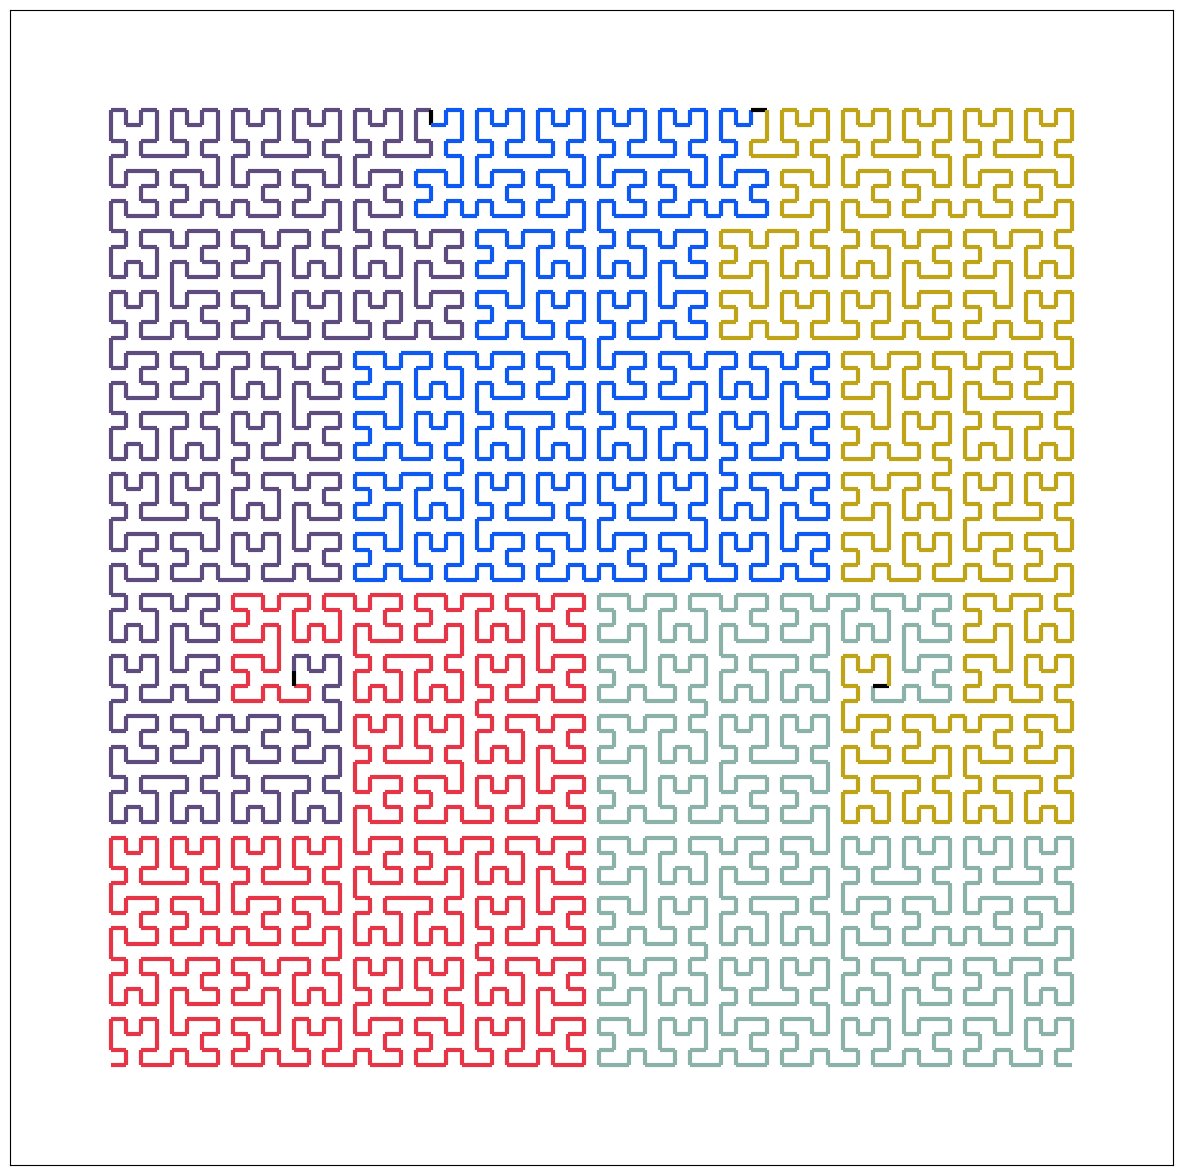

In [40]:

print("grid_in_morton_order: ",morton_order)

partition_size = (node_count)//partition_count
large_partition_count = node_count % partition_count
morton_only_partition_labels = [-1 for _ in range(len(data_points))]

centers = []

for partition_idx in range(partition_count):

    if partition_idx < large_partition_count:
        size = partition_size+1
        offset = partition_idx*(partition_size+1)
    else:
        size = partition_size
        offset = large_partition_count*(partition_size+1) + (partition_idx-large_partition_count)*partition_size
    for i in range(offset, offset+size):
        morton_only_partition_labels[morton_order[i]] = partition_idx
        # print(morton_order[i])

  


print(morton_only_partition_labels)
morton_G_edges = morton_G.edges()
morton_G_edge_colors = []
for u,v in morton_G_edges:
    partition_u = morton_only_partition_labels[u]
    partition_v = morton_only_partition_labels[v]
    if partition_u==partition_v:
        morton_G_edge_colors.append(cluster_to_color(partition_u))
    else:
        morton_G_edge_colors.append('black')
# colors = [G[u][v]['color'] for u,v in hilbert_G_edges]
print(set(morton_G_edge_colors))
plt.figure(figsize=(fig_size,fig_size))

nx.draw_networkx_edges(morton_G, pos,edge_color=morton_G_edge_colors,width=3)
plt.show()


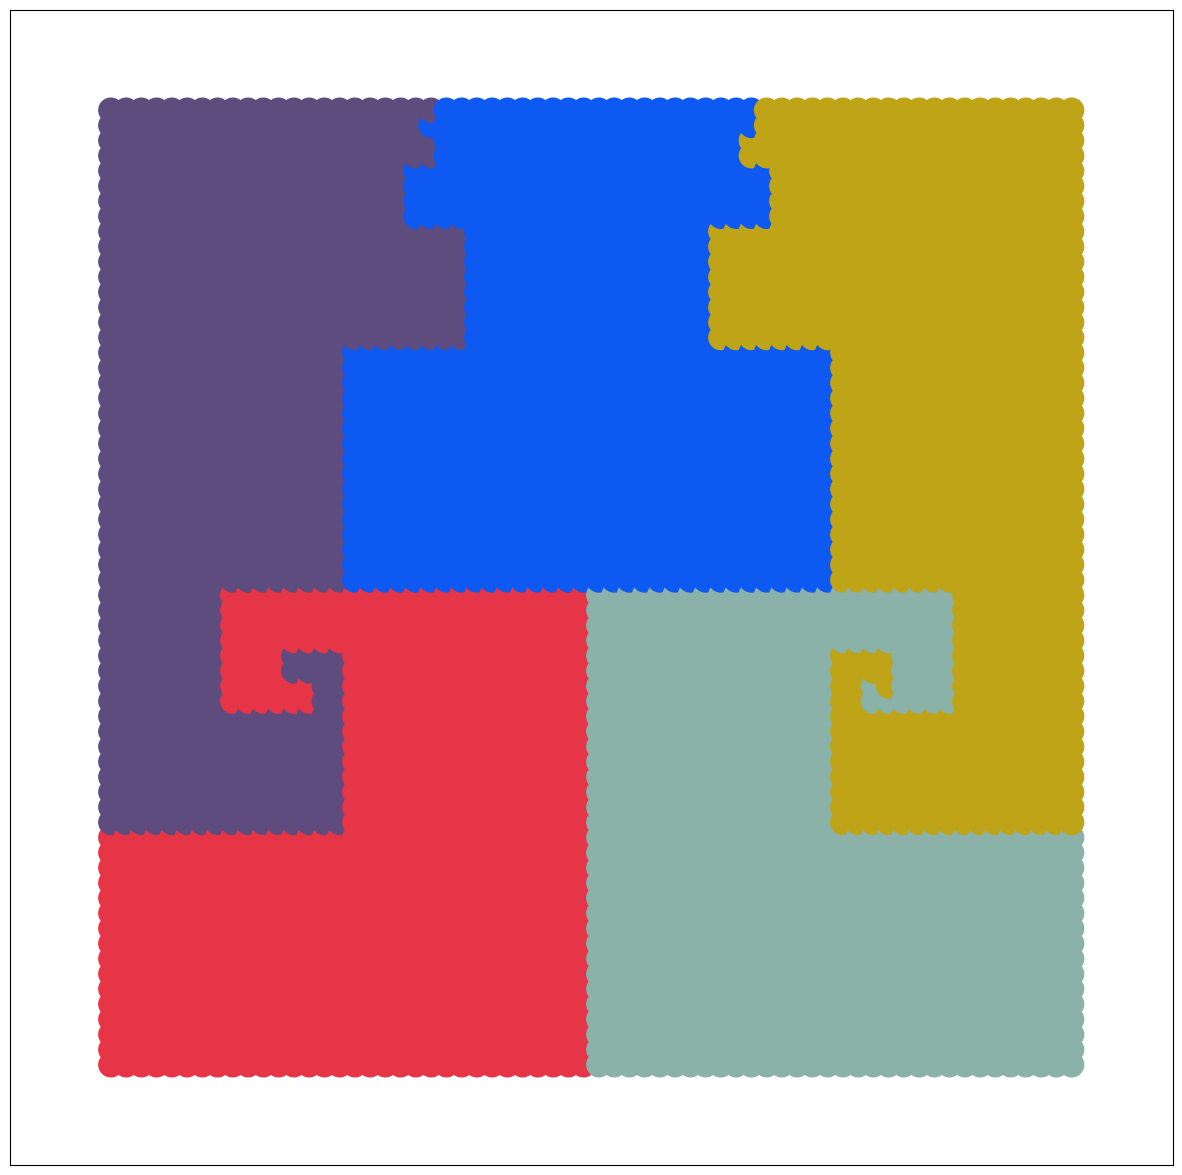

In [41]:
node_color=[cluster_to_color(c) for c in morton_only_partition_labels]
lbls = {}
plt.figure(figsize=(fig_size,fig_size))
nx.draw_networkx(G, pos,node_color=node_color,labels=lbls)
plt.show()

In [42]:
# cluster_label = [-1 for i in range(node_count)]
# cluster_distance = [float('inf') for i in range(node_count)]







# for center in centers:
#     li=0

#     for layer in nx.bfs_layers(G,[center]):
#         if li==0:
#             cluster_label[layer[0]] = center
#             cluster_distance[layer[0]] = 0
#             li+=1
#             continue

#         # print(layer)
#         for x in layer:
#             if li < cluster_distance[x]:
#                 cluster_label[x] = center
#                 cluster_distance[x] = li
#         li+=1
# print("centers:", centers)
# print("labels: ", cluster_label)
# # pos = nx.nx_agraph.graphviz_layout(G)
# plt.figure(figsize=(fig_size,fig_size))
# node_color=[cluster_to_color(c) for c in cluster_label]
# labels={}
# for i in range(node_count):
#     labels[i] = ""

# for center in centers:
#     labels[center] = str(center)
# nx.draw_networkx(G, pos,cluster_label,node_color=node_color,labels=labels,font_color='red',font_size=21)
# plt.show()

In [43]:
# partition_sizes = defaultdict(int)
# for cl in cluster_label:
#     partition_sizes[cl]+=1

# edge_cuts = 0

# for u,v in G.edges:
#     if cluster_label[u] != cluster_label[v]:
#         edge_cuts+=1
# # 'method', 'np', 'lambda', 'rho'
# rho = max(partition_sizes.values())/(G.number_of_nodes()/partition_count)
# lmb = edge_cuts/G.number_of_edges()
# s = pd.Series({'method':'SFC BFS', 'np':partition_count,'lambda_expr':f"{edge_cuts}/{G.number_of_edges()}",'lambda': lmb,'rho_expr':f"{max(partition_sizes.values())}/{int(G.number_of_nodes()/partition_count)}",'rho':rho})
# print(edge_cuts)
# results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)

### Morton -> SFC -> Distributed mulitiple BFS with conflict resolve

In [44]:
partition_to_nodes = [set() for _ in range(partition_count)]
node_to_partition = {}

for node,partition_id in enumerate(morton_only_partition_labels):
    partition_to_nodes[partition_id].add(node)
    node_to_partition[node] = partition_id

print(partition_to_nodes)

msg_pass_count = 0

rounds = 3

for round in range(rounds):
    new_partition_labels = [None for lb in morton_only_partition_labels]

    node_requests_to = [[] for _ in range(partition_count)]      # for each process, containes a list of tuple (node, reached distance,requester)
    node_requests_from = [set() for _ in range(partition_count)]
    node_request_replies_to = [set() for _ in range(partition_count)]
    given_nodes = [set() for _ in range(partition_count)]


    partition_id_to_visited = [set() for _ in range(partition_count)]
    partition_id_to_visited_distances = [{} for _ in range(partition_count)]


    # BFS and msg sending step
    for p_i in range(partition_count):
        # subgraph = nx.induced_subgraph(G, list(partition_to_nodes[p_i]))
        # plt.figure(figsize=(fig_size/2,fig_size/2))

        # nx.draw_networkx(subgraph,pos)
        # plt.show()

        current_partition_size = len(partition_to_nodes[p_i])
        bfs_limit = 2* math.ceil(math.log2(current_partition_size))

        components = []
        not_visited = partition_to_nodes[p_i].copy()
        frontier = set()
        visited = set()
        visited_distance = {}
        # print("partition:",p_i)
        distance = 0
        # frontier.add(min(partition_to_nodes[p_i]))       # later change this to start from center
        frontier.add(list(partition_to_nodes[p_i])[len(partition_to_nodes[p_i])//2])
        
        # visited.add(min(partition_to_nodes[p_i]))
        while distance < bfs_limit:
            next_frontier = set()
            for f in frontier:
                visited.add(f)
                visited_distance[f] = distance
                for n in G.neighbors(f):
                    if (n not in visited) and (n not in frontier):
                        next_frontier.add(n)
            distance+=1
            frontier = next_frontier
            # print(p_i, frontier)
            # print(p_i,visited_distance)

        # print()

        partition_id_to_visited[p_i] = visited.copy()
        partition_id_to_visited_distances[p_i] = copy.deepcopy(visited_distance)

        # check visited nodes, if there are nodes currently in other partitions, request them
        for v in visited:
            if node_to_partition[v]!=p_i:
                node_requests_to[node_to_partition[v]].append((v,visited_distance[v],p_i))
                node_requests_from[p_i].add(v)
                msg_pass_count+=1
    # display(node_requests_to)
    # display(partition_id_to_visited)
    # display(partition_id_to_visited_distances)

    # resolving conflicts and sending replies
    for p_i in range(partition_count):
        requested_all_nodes = set()
        for req in node_requests_to[p_i]:
            requested_all_nodes.add(req[0])
        for req_node in requested_all_nodes:
            reqs_for_node = filter(lambda x: x[0]==req_node, node_requests_to[p_i])
            min_dist_request = min(reqs_for_node, key=itemgetter(0))
            if (req_node not in partition_id_to_visited[p_i]) or (min_dist_request[1] < partition_id_to_visited_distances[p_i][req_node]):      # if better than my reached distance
                node_request_replies_to[min_dist_request[2]].add(req_node)
                given_nodes[p_i].add(req_node)
                msg_pass_count+=1

    node_to_partition = {}
    #handling replies and adjusting partitions
    for p_i in range(partition_count):
        old_partition_labels = [lb for lb in new_partition_labels]
        current_nodes_in_my_partition = partition_to_nodes[p_i]
        nodes_in_my_new_partition = set()
        for v in node_requests_from[p_i]:       # I requested these nodes
            if v in node_request_replies_to[p_i]:           # I got it!
                nodes_in_my_new_partition.add(v)
                node_to_partition[v] = p_i

        for v in current_nodes_in_my_partition: #in all other nodes in my current partition
            if v not in given_nodes[p_i]:       # if I did not give this to anyone
                nodes_in_my_new_partition.add(v)    # Then it's mine
                node_to_partition[v] = p_i
        partition_to_nodes[p_i] = nodes_in_my_new_partition

    for node in node_to_partition:
        new_partition_labels[node] = node_to_partition[node]

    for lb in new_partition_labels:
        assert(not(lb is None))




# display(partition_to_nodes)

print("message count",msg_pass_count)
partition_sizes = defaultdict(int)
for lb in new_partition_labels:
    partition_sizes[lb]+=1

edge_cuts = 0

for u,v in G.edges:
    if new_partition_labels[u] != new_partition_labels[v]:
        edge_cuts+=1
# 'method', 'np', 'lambda', 'rho'
rho = max(partition_sizes.values())/(G.number_of_nodes()/partition_count)
lmb = edge_cuts/G.number_of_edges()
s = pd.Series({'method':'SFC+dis BFS', 'np':partition_count,'lambda_expr':f"{edge_cuts}/{G.number_of_edges()}",'lambda': lmb,'rho_expr':f"{max(partition_sizes.values())}/{int(G.number_of_nodes()/partition_count)}",'rho':rho})

results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)







    

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 536, 537, 538, 539, 540, 541, 542, 543, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 600, 601, 602, 603, 604, 605, 606, 607, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 664, 665, 666, 667, 668, 669, 670, 671, 704, 705, 706, 707, 708, 709, 710, 711, 

/tmp/ipykernel_21223/1429599531.py:133: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)


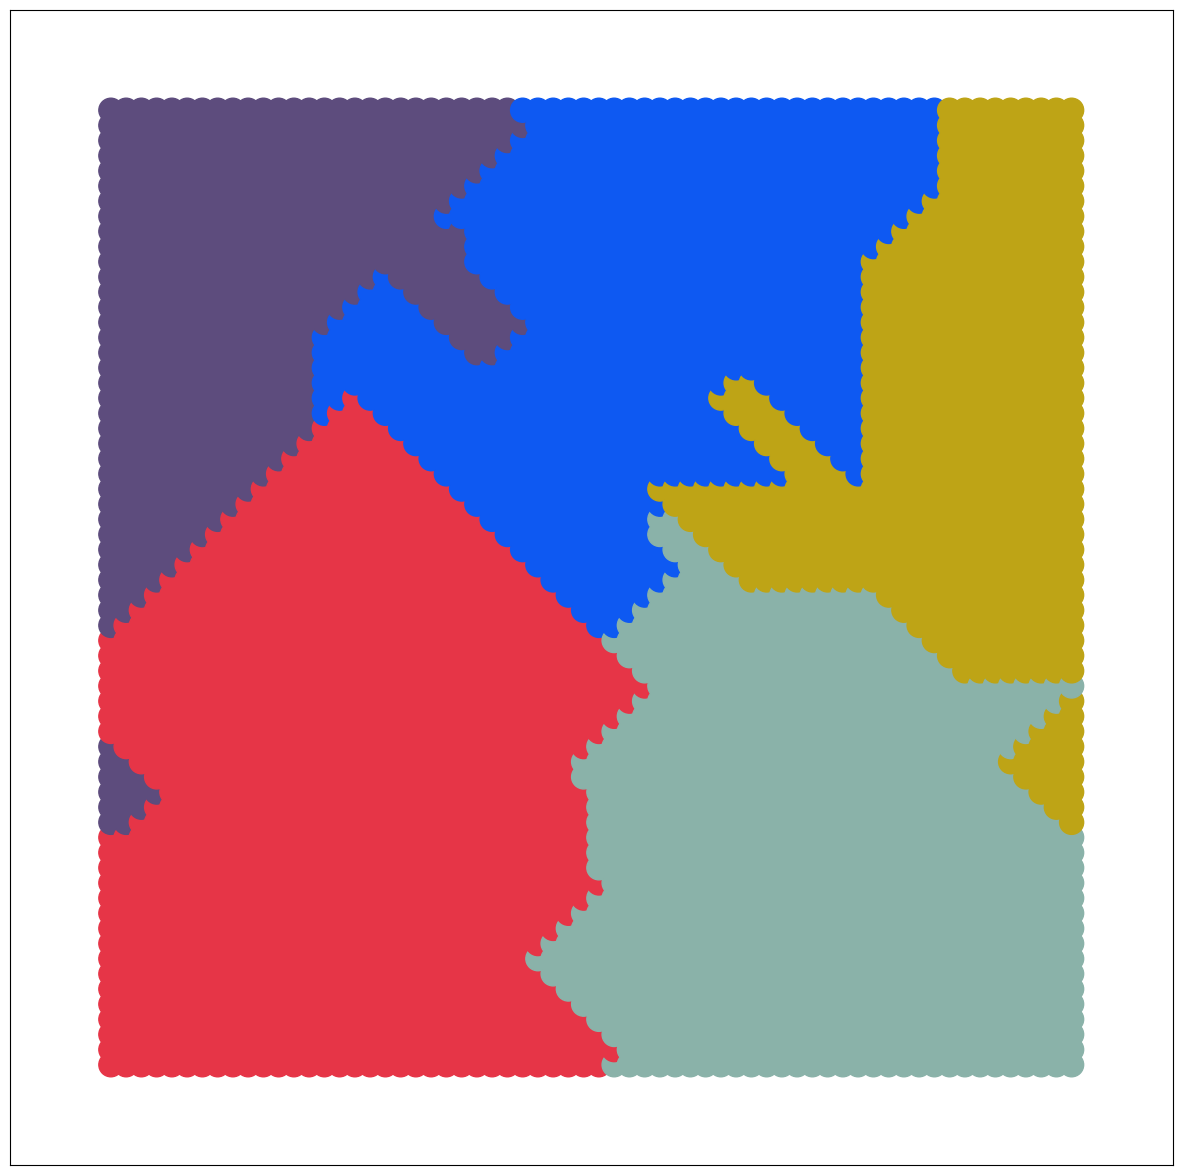

In [45]:
node_color=[cluster_to_color(c) for c in new_partition_labels]
# labels_metis = {}
lbls={}
plt.figure(figsize=(fig_size,fig_size))
nx.draw_networkx(G, pos,node_color=node_color,labels=lbls)
plt.show()

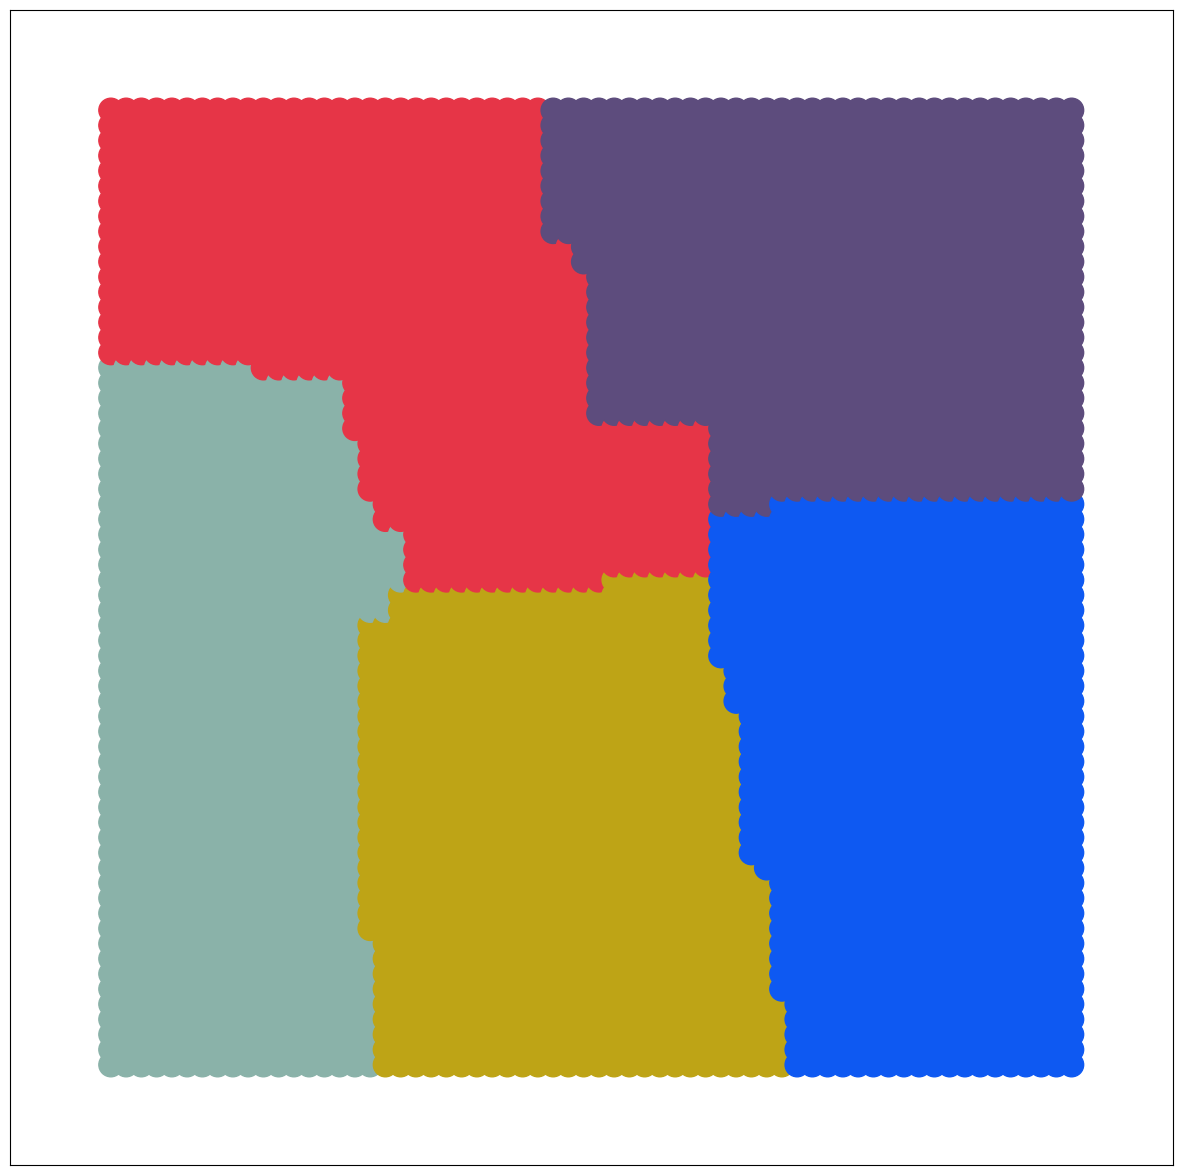

In [46]:
(edgecuts, metis_parts_labels) = metis.part_graph(G, partition_count)
node_color_metis=[cluster_to_color(c) for c in metis_parts_labels]
labels_metis = {}
plt.figure(figsize=(fig_size,fig_size))
nx.draw_networkx(G, pos,node_color=node_color_metis,labels=labels_metis)
plt.show()


In [47]:
partition_sizes_metis = defaultdict(int)
for cl in metis_parts_labels:
    partition_sizes_metis[cl]+=1

edge_cuts_metis = 0

for u,v in G.edges:
    if metis_parts_labels[u] != metis_parts_labels[v]:
        edge_cuts_metis+=1
# 'method', 'np', 'lambda', 'rho'
rho_metis = max(partition_sizes_metis.values())/(G.number_of_nodes()/partition_count)
lmb_metis = edge_cuts_metis/G.number_of_edges()
s = pd.Series({'method':'METIS', 'np':partition_count,'lambda_expr':f"{edge_cuts_metis}/{G.number_of_edges()}",'lambda': lmb_metis,'rho_expr':f"{max(partition_sizes_metis.values())}/{int(G.number_of_nodes()/partition_count)}",'rho':rho_metis})

results = pd.concat([results, pd.DataFrame([s])],ignore_index=True)

In [48]:
print(results)

        method np lambda_expr    lambda  rho_expr       rho
0  SFC+dis BFS  5    334/8064  0.041419  1172/819  1.430664
1        METIS  5    197/8064  0.024430   825/819  1.007080
